# SBB

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np

## Import Data

In [136]:
df = pd.read_csv('data/zugzahlen.csv')

In [137]:
df.head(5)

,PID,ISB,Strecke_Nummer,Strecke_Bezeichnung,Strecke_Art,BP_Von_Abschnitt,BP_Von_Abschnitt_Bezeichnung,BP_Bis_Abschnitt,BP_Bis_Abschnitt_Bezeichnung,Anzahl_Zuege,BPUIC,KOORDZ,KOORDY,KOORDX,Name Haltestelle,TU Nummer,Bedienpunkt Cargo,land,geopos_von,geopos_bis
0,SBB_GESE_CHY,SBB,1,Genève Aéroport - Lausanne,STRECKE,GESE,Genève-Sécheron,CHY,Chambésy,126307,8516283,390.4,500153.08,119825.45,Genève-Sécheron,11,None,Switzerland,"6.14454714955, 46.2224480511","6.14732717469, 46.2423883571"
1,SBB_MIES_TAN,SBB,1,Genève Aéroport - Lausanne,STRECKE,MIES,Mies,TAN,Tannay,126101,8501014,394.7,502222.94,128400.90,Mies,11,None,Switzerland,"6.16956925257, 46.2998837999","6.18111951391, 46.3076442488"
2,SBB_MOR_STJ,SBB,1,Genève Aéroport - Lausanne,STRECKE,MOR,Morges,STJ,Morges-St-Jean,121566,8501037,381.2,527498.18,151525.28,Morges,11,*,Switzerland,"6.49396657295, 46.5110943408","6.5080466068, 46.5181943179"
3,SBB_TUI_GDBE,SBB,1,Genève Aéroport - Lausanne,STRECKE,TUI,Les Tuileries,GDBE,Genthod-Bellevue,126311,8501011,389.2,500417.99,122879.65,Les Tuileries,11,None,Switzerland,"6.14732757249, 46.2499580317","6.15395779335, 46.2567477219"
4,SBB_RUS_SY,SBB,3,La Plaine Frontière - Genève,STRECKE,RUS,Russin,SY,Satigny,40988,8501002,377.9,490285.68,116142.90,Russin,11,None,Switzerland,"6.01754977864, 46.1877882306","6.03749960767, 46.2142381831"


In [138]:
df['lon_von'] = df.geopos_von.str.split('\,').str[0]
df['lon_von'] = df['lon_von'].map(float)

In [139]:
df['lat_von'] = df.geopos_von.str.split('\,').str[1]
df['lat_von'] = df['lat_von'].map(float)

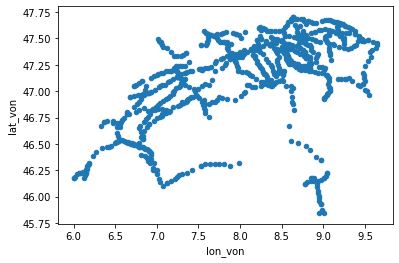

In [140]:
df.plot.scatter(x='lon_von', y ='lat_von');

In [141]:
df['lon_bis'] = df.geopos_bis.str.split('\,').str[0]
df['lon_bis'] = df['lon_bis'].map(float)

In [142]:
df['lat_bis'] = df.geopos_bis.str.split('\,').str[1]
df['lat_bis'] = df['lat_bis'].map(float)

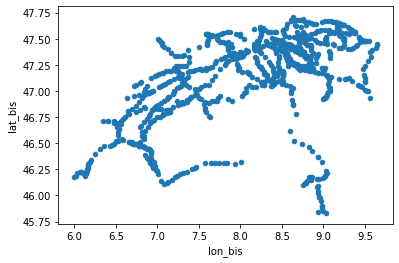

In [143]:
df.plot.scatter(x='lon_bis', y ='lat_bis');

In [144]:
pos_von = {}
for i in range(0, len(df)):
    pos_von[df.BP_Von_Abschnitt[i]] = (df.lon_von[i], df.lat_von[i])

In [145]:
pos_von

{'GESE': (6.14454714955, 46.2224480511),
 'MIES': (6.16956925257, 46.2998837999),
 'MOR': (6.49396657295, 46.5110943408),
 'TUI': (6.14732757249, 46.2499580317),
 'RUS': (6.01754977864, 46.1877882306),
 'ZIM': (6.06572961816, 46.2212782881),
 'CL': (6.89577416732, 46.4427363866),
 'MX': (6.91043416362, 46.4358764283),
 'RIV': (6.78458512784, 46.4741959259),
 'STSA': (6.79702513762, 46.4725859812),
 'TER': (6.92269446132, 46.4263764483),
 'BDR': (6.83505431971, 46.9594460636),
 'CC': (6.72317472087, 46.8508755224),
 'GRS': (6.64194298034, 46.8062746752),
 'TWN': (7.15649883305, 47.0936548007),
 'BELL': (7.50786664414, 47.2088961768),
 'PIE': (7.34019644684, 47.1714251426),
 'SW': (7.53194669287, 47.2067062508),
 'EG': (7.79895396666, 47.3148570917),
 'NB': (7.69481442016, 47.2703871142),
 'WAA': (7.65622530299, 47.231947095),
 'BRT': (6.47473518659, 46.7150539002),
 'CR': (6.47812521581, 46.6967041225),
 'TR': (6.6765762976, 46.9424063665),
 'CHN': (6.81226410919, 46.9671059769),
 'LOC'

In [146]:
pos_bis = {}
for i in range(0, len(df)):
    pos_bis[df.BP_Bis_Abschnitt[i]] = (df.lon_bis[i], df.lat_bis[i])

In [147]:
pos_bis

{'CHY': (6.14732717469, 46.2423883571),
 'TAN': (6.18111951391, 46.3076442488),
 'STJ': (6.5080466068, 46.5181943179),
 'GDBE': (6.15395779335, 46.2567477219),
 'SY': (6.03749960767, 46.2142381831),
 'VM': (6.07690984868, 46.2223483406),
 'MX': (6.91043416362, 46.4358764283),
 'TER': (6.92269446132, 46.4263764483),
 'STSA': (6.79702513762, 46.4725859812),
 'VV': (6.84344455538, 46.4629962321),
 'VEY': (6.92785479694, 46.4176161625),
 'CLB': (6.84888396056, 46.9676359617),
 'LLA': (6.74136494021, 46.8595357903),
 'ONB': (6.68993413176, 46.8325152002),
 'TUE': (7.1973078466, 47.1149947654),
 'BELE': (7.49534638898, 47.2085261387),
 'BIBD': (7.29459729258, 47.1583849693),
 'SOAD': (7.52143688631, 47.2088661856),
 'HRK': (7.81845403287, 47.3216070118),
 'OEN': (7.70985453082, 47.2850170066),
 'NB': (7.69481442016, 47.2703871142),
 'CR': (6.47812521581, 46.6967041225),
 'AX': (6.51890509252, 46.6980742045),
 'CVT': (6.63403500081, 46.9303761939),
 'CP': (6.88381357009, 46.9833458596),
 'CRE

In [148]:
pos = {**pos_bis, **pos_von}

In [149]:
len(pos)

1002

## Building the Network

In [150]:
D = nx.from_pandas_edgelist(df, source = 'BP_Von_Abschnitt', target = 'BP_Bis_Abschnitt', edge_attr = 'Anzahl_Zuege', create_using = nx.DiGraph())

In [151]:
len(D.nodes())

1002

In [152]:
len(D.edges())

848

In [153]:
D.edges(data=True)

OutEdgeDataView([('GESE', 'CHY', {'Anzahl_Zuege': 126307}), ('GESE', 'GEVO', {'Anzahl_Zuege': 8465}), ('CHY', 'VEN', {'Anzahl_Zuege': 126310}), ('MIES', 'TAN', {'Anzahl_Zuege': 126101}), ('TAN', 'COP', {'Anzahl_Zuege': 126100}), ('MOR', 'STJ', {'Anzahl_Zuege': 121566}), ('STJ', 'LON', {'Anzahl_Zuege': 121566}), ('TUI', 'GDBE', {'Anzahl_Zuege': 126311}), ('GDBE', 'CRGD', {'Anzahl_Zuege': 126311}), ('RUS', 'SY', {'Anzahl_Zuege': 40988}), ('SY', 'ZIM', {'Anzahl_Zuege': 40988}), ('ZIM', 'VM', {'Anzahl_Zuege': 40990}), ('VM', 'VMC', {'Anzahl_Zuege': 40990}), ('CL', 'MX', {'Anzahl_Zuege': 56090}), ('MX', 'TER', {'Anzahl_Zuege': 60062}), ('MX', 'VERX', {'Anzahl_Zuege': 3732}), ('TER', 'VEY', {'Anzahl_Zuege': 60066}), ('RIV', 'STSA', {'Anzahl_Zuege': 82741}), ('RIV', 'GRIL', {'Anzahl_Zuege': 5119}), ('STSA', 'VV', {'Anzahl_Zuege': 82745}), ('VV', 'TOUR', {'Anzahl_Zuege': 59839}), ('VEY', 'VIL', {'Anzahl_Zuege': 60062}), ('BDR', 'CLB', {'Anzahl_Zuege': 43879}), ('CLB', 'AUV', {'Anzahl_Zuege': 4

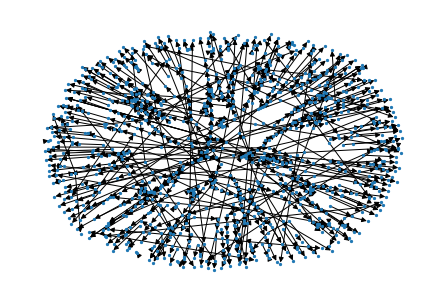

In [154]:
nx.draw(D, with_labels=False, node_size=5)

In [155]:
G = nx.Graph(D)

In [156]:
len(G.nodes())

1002

In [157]:
len(G.edges())

848

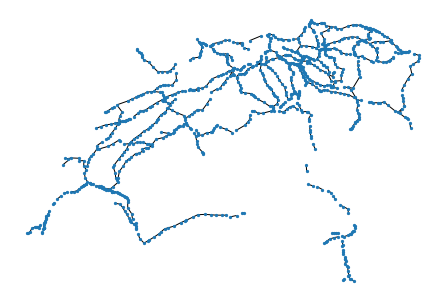

In [158]:
nx.draw(G, pos=pos, with_labels=False, node_size=5)